In [67]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import proplot as plot
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr #proplot需要在rioxarray导入之前导入 不然会报错

#### gurla 地区

In [177]:
#######
kh_gurla=xr.open_dataset('TOPO_KH9_RES\\gurla-mandhata_315\\DH_1966KH4_2000AST_GurlaMandhata_v10052021.tif',engine='rasterio').rio.reproject('epsg:4326')
kh_gurla=kh_gurla['band_data']
kh_gurla.name='kh_dh'

############
dxt_gurla=xr.open_dataset('TOPO_KH9_RES\\gurla-mandhata_315\\g0315_dh_final.tif',engine='rasterio')
dxt_prj=dxt_gurla.rio.reproject('epsg:4326')['band_data']
#dxt_prj.where((dxt_prj<10)&(dxt_prj>-100))
dxt_prj.name='dh'

dxt_inp=dxt_prj.interp(x=kh_gurla.x.values,y=kh_gurla.y.values,method='nearest')
################################
dem=xr.open_dataset('TOPO_KH9_RES\\gurla-mandhata_315\\g0315_srtm.tif',engine='rasterio')
dem_prj=dem.rio.reproject('epsg:4326')['band_data']
dem_prj=dem_prj.where(dem_prj!=32767)

dem_inp=dem_prj.interp(x=kh_gurla.x.values,y=kh_gurla.y.values)
dem_inp.name='dem'

In [178]:
ds_gla=gpd.read_file('TOPO_KH9_RES\\gurla-mandhata_315\\g0315_gla.shp')
ds_gla=ds_gla.to_crs('epsg:4326')
dxt_inp0=dxt_inp.rio.clip(ds_gla.geometry)

In [179]:
df=dem_inp.to_dataframe().drop('spatial_ref',axis=1)  ###非冰川区的专为dataframe 进行统计绘图
df_dh=dxt_inp0.to_dataframe().drop('spatial_ref',axis=1)
df_khdh=kh_gurla.to_dataframe().drop('spatial_ref',axis=1)

df_all=pd.concat([df_dh,df_khdh,df],axis=1).dropna()

In [180]:
df_all['dh'].mean()/26,df_all['kh_dh'].mean()/25

(-0.15521872960604155, -0.26525102615356444)

In [181]:
'''generate strip positions and interval center by interval'''
def ExtractByStrip(df,strip_sign,outsign,interval):
    #val_min=df[strip_sign].min()
    #val_max=df[strip_sign].max()
    val_min=1000
    val_max=8500
    #print(val_min,val_max)
    #n=int((val_max-val_min)/interval)
    df[outsign]=-1
    x=val_min
    while x<val_max:
        y=x+interval
        if y>=val_max:
            y=val_max+1
        df.loc[((df[strip_sign]>=x)&(df[strip_sign]<y)),outsign] =(x+y)/2.0
        x=y
    return df

In [182]:
df_sta=ExtractByStrip(df_all,'dem','flag',100)

C:\Users\zhuyu\AppData\Local\Temp\ipykernel_22828\1302932519.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8450.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[((df[strip_sign]>=x)&(df[strip_sign]<y)),outsign] =(x+y)/2.0


In [183]:
####绘图用统计
dff_pt=df_sta.groupby('flag')
q25=dff_pt.quantile(0.25)
q75=dff_pt.quantile(0.75)
q05=dff_pt.quantile(0.05)
q95=dff_pt.quantile(0.95)
std=dff_pt.std()
mea=dff_pt.mean()
cnt=dff_pt.count()

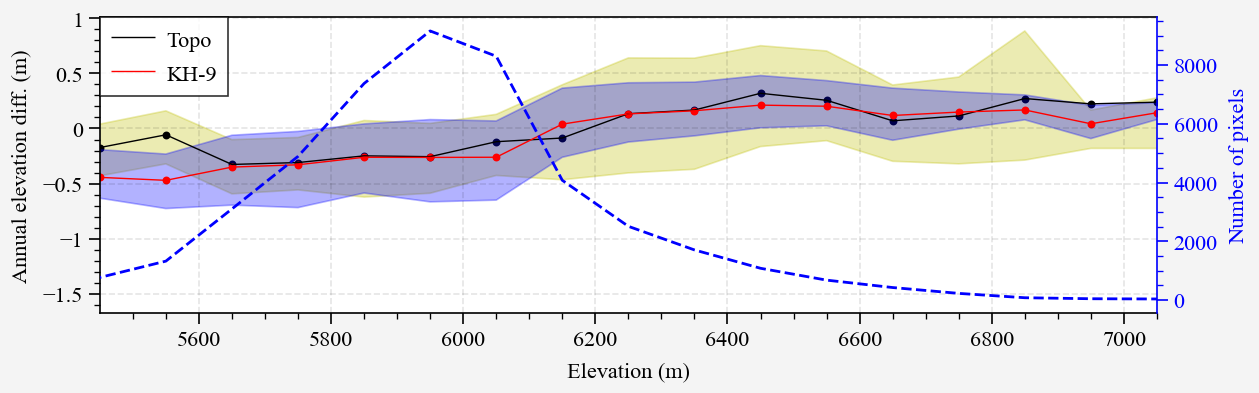

In [123]:
from matplotlib.font_manager import FontProperties
plt.rcParams['font.size'] = 8
plt.rcParams['font.sans-serif']='times new roman'
plt.rcParams['grid.linestyle']='--'
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")#中文支持，很重要
font1 = FontProperties(family='times new roman',style='normal',weight='normal') #设置新罗马

plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
arr=[[1,]]
fig, axs = plot.subplots(arr, figsize=('16cm','5cm'),
                         sharex=0,sharey=0,hspace=0.05,wspace=0.24)
################ topo
lg1=axs[0].fill_between(q25.index,q25['dh'].values/26, q75['dh'].values/26,alpha=0.3,color='y')
#lg2=axs[0].fill_between(q05.index,q05['dh'].values, q95['dh'].values,alpha=0.3,color='gray')
lg3=axs[0].scatter(mea.index,mea['dh'].values/26,marker='.',s=20,color='k')
lg3=axs[0].plot(mea.index,mea['dh'].values/26,color='k',lw=0.5)

axt=axs[0].twinx()
axt.plot(cnt.dem,ls='--',lw=1,c='b')
#######
################ topo
lg1=axs[0].fill_between(q25.index,q25['kh_dh'].values/34, q75['kh_dh'].values/34,alpha=0.3,color='b')
#lg2=axs[0].fill_between(q05.index,q05['kh_dh'].values, q95['kh_dh'].values,alpha=0.3,color='b')
lg2=axs[0].scatter(mea.index,mea['kh_dh'].values/34,marker='.',s=20,color='r')
lg31=axs[0].plot(mea.index,mea['kh_dh'].values/34,color='r',lw=0.5)
axs[0].format(xlim=(5450,7050),ylabel='Annual elevation diff. (m)',xlabel='Elevation (m)')
axt.format(ylabel='Number of pixels',ycolor='b')
axs[0].legend([lg3,lg31],['Topo','KH-9'],loc=2,ncol=1,borderaxespad=0)
#plt.savefig('00fig_out/comparision_gurla.svg',dpi=300,bbox_inches = 'tight')

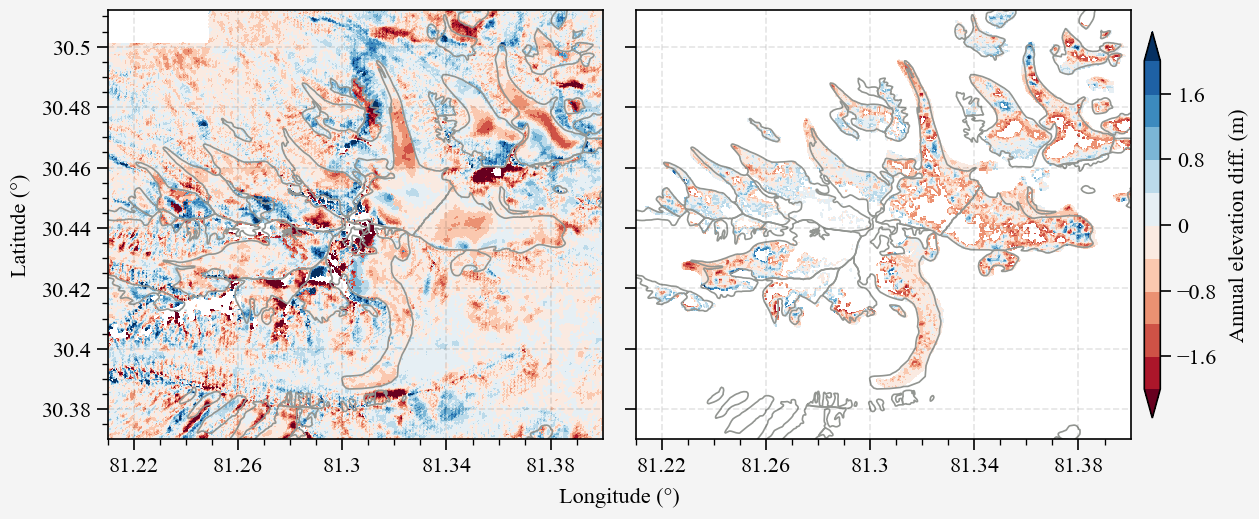

In [124]:
plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
plt.rcParams['grid.linestyle']='--'
arr=[[1,2]]
fig, axs = plot.subplots(arr, figsize=('16cm','6.6cm'),
                         share=1,hspace=0.05,wspace=0.24)

cs1=axs[0].pcolormesh((dxt_prj/26)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
ds_gla.plot(ax=axs[0],facecolor='none',edgecolor='gray')
#axs[0].colorbar(cs1, loc='b',length=0.85,width=0.080,tickminor=False,pad=0,extend='both',
#                label='Annual elevation diff. (m)')
#dem_prj.plot(ax=axs[0],add_colorbar=False)
##########3
cs2=axs[1].pcolormesh((kh_gurla/34)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
ds_gla.plot(ax=axs[1],facecolor='none',edgecolor='gray')
axs[1].colorbar(cs2, loc='r',length=0.9,width=0.080,tickminor=False,pad=0.5,extend='both',
               label='Annual elevation diff. (m)')
axs.format(ylim=(30.37,30.512),xlim=(81.21,81.4),title='',
           xlabel='Longitude (°)',ylabel='Latitude (°)',grid=True,
           xticks=[81.22,81.26,81.3,81.34,81.38])
axs[1].format(yticklabels=[])

#plt.savefig('00fig_out/comparision_gurla_img1-large.tif',dpi=600,bbox_inches = 'tight')

#### poiqu

In [185]:
#######
kh_pq=xr.open_dataset('TOPO_KH9_RES\\poiqu_336\\DH_1974KH9_2004AST_Poiqu_v10052021.tif',engine='rasterio').rio.reproject('epsg:4326')
kh_pq.name='kh_dh'

############
dxt_pq=xr.open_dataset('TOPO_KH9_RES\\poiqu_336\\g0336_dh_final.tif',engine='rasterio')
dxt_prj_pq=dxt_pq.rio.reproject('epsg:4326')['band_data']
dxt_prj_pq.name='dh'

dxt_inp_pq=dxt_prj_pq.interp(x=kh_pq.x.values,y=kh_pq.y.values)
################################
dem_pq=xr.open_dataset('TOPO_KH9_RES\\poiqu_336\\g0336_srtm.tif',engine='rasterio')
dem_prj_pq=dem_pq.rio.reproject('epsg:4326')['band_data']
dem_prj_pq=dem_prj_pq.where(dem_prj_pq!=32767)

dem_inp_pq=dem_prj_pq.interp(x=kh_pq.x.values,y=kh_pq.y.values)
dem_inp_pq.name='dem'

In [127]:
#dxt_inp_pq0.where((dxt_inp_pq0>-100)&(dxt_inp_pq0<100)).plot()

In [128]:
#kh_pq.plot()

In [186]:
ds_gla_pq=gpd.read_file('TOPO_KH9_RES\\poiqu_336\\g0336_gla.shp')
ds_gla_pq=ds_gla_pq.to_crs('epsg:4326')
dxt_inp_pq0=dxt_inp_pq.rio.clip(ds_gla_pq.geometry)

In [187]:
df=dem_inp_pq.to_dataframe().drop('spatial_ref',axis=1)  ###非冰川区的专为dataframe 进行统计绘图
df_dh=dxt_inp_pq0.to_dataframe().drop('spatial_ref',axis=1)
df_khdh=kh_pq.to_dataframe().drop('spatial_ref',axis=1)

In [188]:
df_all=pd.concat([df_dh,df_khdh,df],axis=1).dropna()

In [189]:
df_sta=ExtractByStrip(df_all,'dem','flag',100)

C:\Users\zhuyu\AppData\Local\Temp\ipykernel_22828\1302932519.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8450.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[((df[strip_sign]>=x)&(df[strip_sign]<y)),outsign] =(x+y)/2.0


In [190]:
####绘图用统计
dff_pt_pq=df_sta.groupby('flag')
q25_pq=dff_pt_pq.quantile(0.25)
q75_pq=dff_pt_pq.quantile(0.75)
q05_pq=dff_pt_pq.quantile(0.05)
q95_pq=dff_pt_pq.quantile(0.95)
std_pq=dff_pt_pq.std()
mea_pq=dff_pt_pq.mean()
cnt_pq=dff_pt_pq.count()

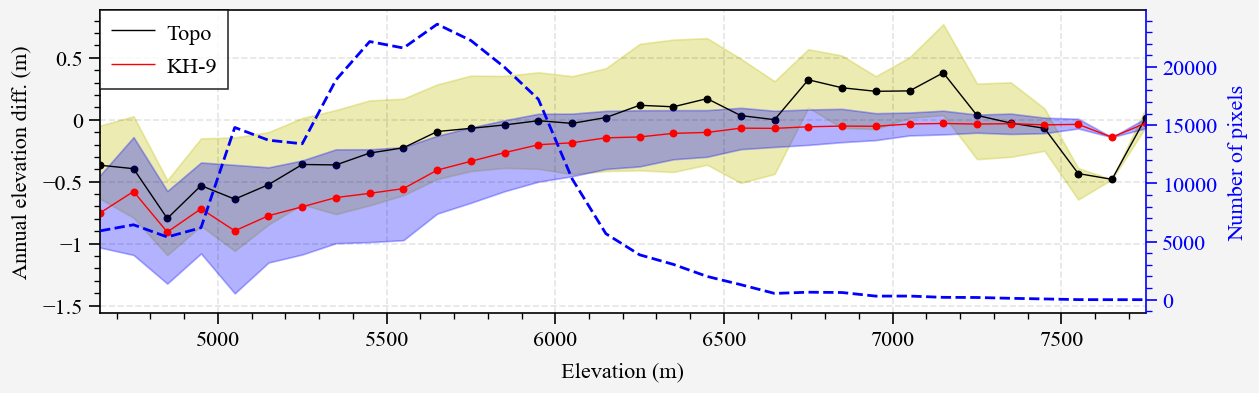

In [191]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")#中文支持，很重要
font1 = FontProperties(family='times new roman',style='normal',weight='normal') #设置新罗马

plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
arr=[[1,]]
fig, axs = plot.subplots(arr, figsize=('16cm','5cm'),
                         sharex=0,sharey=0,hspace=0.05,wspace=0.24)
################ topo
lg1=axs[0].fill_between(q25_pq.index,q25_pq['dh'].values/26, q75_pq['dh'].values/26,alpha=0.3,color='y')
#lg2=axs[0].fill_between(q05.index,q05['dh'].values, q95['dh'].values,alpha=0.3,color='gray')
lg2=axs[0].scatter(mea_pq.index,mea_pq['dh'].values/26,marker='.',s=20,color='k')
lg3=axs[0].plot(mea_pq.index,mea_pq['dh'].values/26,color='k',lw=0.5)

axt=axs[0].twinx()
axt.plot(cnt_pq.dem,ls='--',lw=1,c='b')
#######
################ topo
lg1=axs[0].fill_between(q25_pq.index,q25_pq['kh_dh'].values/30, q75_pq['kh_dh'].values/30,alpha=0.3,color='b')
#lg2=axs[0].fill_between(q05.index,q05['kh_dh'].values, q95['kh_dh'].values,alpha=0.3,color='b')
lg2=axs[0].scatter(mea_pq.index,mea_pq['kh_dh'].values/30,marker='.',s=20,color='r')
lg31=axs[0].plot(mea_pq.index,mea_pq['kh_dh'].values/30,color='r',lw=0.5)

axs[0].format(xlim=(4650,7750),ylabel='Annual elevation diff. (m)',xlabel='Elevation (m)')
axt.format(ylabel='Number of pixels',ycolor='b')
axs[0].legend([lg3,lg31],['Topo','KH-9'],loc=2,ncol=1,borderaxespad=0)
#plt.savefig('00fig_out/comparision_poiqu.svg',dpi=300,bbox_inches = 'tight')

In [192]:
dxt_prj_pq11=dxt_prj_pq.sel(x=dxt_prj_pq.x.values[::2],y=dxt_prj_pq.y.values[::2])
kh_pq1=kh_pq.sel(x=kh_pq.x.values[::2],y=kh_pq.y.values[::2])

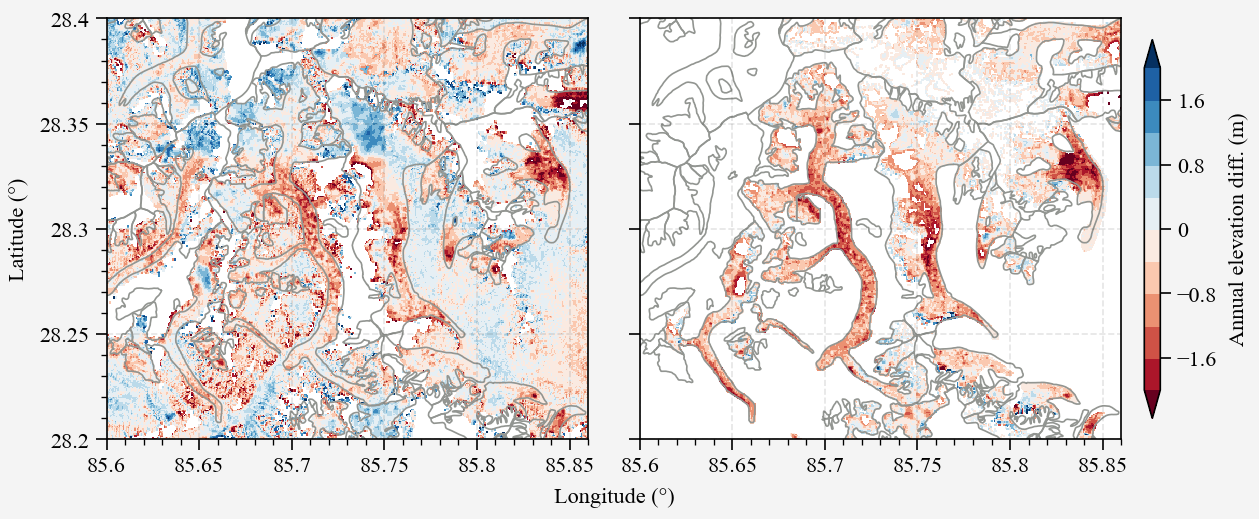

In [193]:
arr=[[1,2]]
fig, axs = plot.subplots(arr, figsize=('16cm','6.6cm'),
                         share=1,hspace=0.05,wspace=0.24)

#cs1=(dxt_prj1/26).plot(ax=axs[0],add_colorbar=False,vmax=2,vmin=-2,cmap='coolwarm')
cs1=axs[0].pcolormesh((dxt_prj_pq11/26)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
ds_gla_pq.plot(ax=axs[0],facecolor='none',edgecolor='gray')
#axs[0].colorbar(cs1, loc='b',length=0.85,width=0.080,tickminor=False,pad=0.3,extend='both',
#                label='Annual elevation diff. (m)')
#dem_prj.plot(ax=axs[0],add_colorbar=False)
##########3
#cs2=(kh_gurla1/30).plot(ax=axs[1],add_colorbar=False,vmax=2,vmin=-2,cmap='coolwarm')
cs2=axs[1].pcolormesh((kh_pq1/30)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
ds_gla_pq.plot(ax=axs[1],facecolor='none',edgecolor='gray')
axs[1].colorbar(cs2, loc='r',length=0.9,width=0.080,tickminor=False,pad=0.3,extend='both',
               label='Annual elevation diff. (m)')
axs.format(ylim=(28.2,28.4),xlim=(85.60,85.86),title='',
           xlabel='Longitude (°)',ylabel='Latitude (°)',grid=True,
           yticks=[28.2,28.25,28.3,28.35,28.4])
#axs.format(ylim=(28.2,28.4),xlim=(85.60,85.86),title='',xlabel='',ylabel='')
axs[1].format(yticklabels=[])
#plt.savefig('00fig_out/comparision_poiqu_img1-large.tif',dpi=600,bbox_inches = 'tight')

#### westnq 

In [195]:
#######
kh_wq=xr.open_dataset('TOPO_KH9_RES\\westernnyq_236\\DH_1976KH9_2001AST_Western Nyainqentanglha_v10052021.tif',engine='rasterio').rio.reproject('epsg:4326')
kh_wq=kh_wq['band_data']
kh_wq.name='kh_dh'

############
dxt_wq=xr.open_dataset('TOPO_KH9_RES\\westernnyq_236\\g0236_dh_final.tif',engine='rasterio')
dxt_prj_wq=dxt_wq.rio.reproject('epsg:4326')['band_data']
dxt_prj_wq.name='dh'

dxt_inp_wq=dxt_prj_wq.interp(x=kh_wq.x.values,y=kh_wq.y.values)
################################
dem=xr.open_dataset('TOPO_KH9_RES\\westernnyq_236\\g0236_srtm.tif',engine='rasterio')
dem_prj_wq=dem.rio.reproject('epsg:4326')['band_data']
dem_prj_wq=dem_prj_wq.where(dem_prj_wq!=32767)

dem_inp_wq=dem_prj_wq.interp(x=kh_wq.x.values,y=kh_wq.y.values)
dem_inp_wq.name='dem'

In [196]:
ds_gla_wq=gpd.read_file('TOPO_KH9_RES\\westernnyq_236\\g0236_gla.shp')
ds_gla_wq=ds_gla_wq.to_crs('epsg:4326')
dxt_inp_wq0=dxt_inp_wq.rio.clip(ds_gla_wq.geometry)

In [197]:
df=dem_inp_wq.to_dataframe().drop('spatial_ref',axis=1)  ###非冰川区的专为dataframe 进行统计绘图
df_dh=dxt_inp_wq.to_dataframe().drop('spatial_ref',axis=1)
df_khdh=kh_wq.to_dataframe().drop('spatial_ref',axis=1)

In [198]:
df_all=pd.concat([df_dh,df_khdh,df],axis=1).dropna()
df_sta=ExtractByStrip(df_all,'dem','flag',100)

C:\Users\zhuyu\AppData\Local\Temp\ipykernel_22828\1302932519.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8450.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[((df[strip_sign]>=x)&(df[strip_sign]<y)),outsign] =(x+y)/2.0


In [171]:
####绘图用统计
dff_pt_wq=df_sta.groupby('flag')
q25_wq=dff_pt_wq.quantile(0.25)
q75_wq=dff_pt_wq.quantile(0.75)
q05_wq=dff_pt_wq.quantile(0.05)
q95_wq=dff_pt_wq.quantile(0.95)
std_wq=dff_pt_wq.std()
mea_wq=dff_pt_wq.mean()
cnt_wq=dff_pt_wq.count()

#### 绘图1

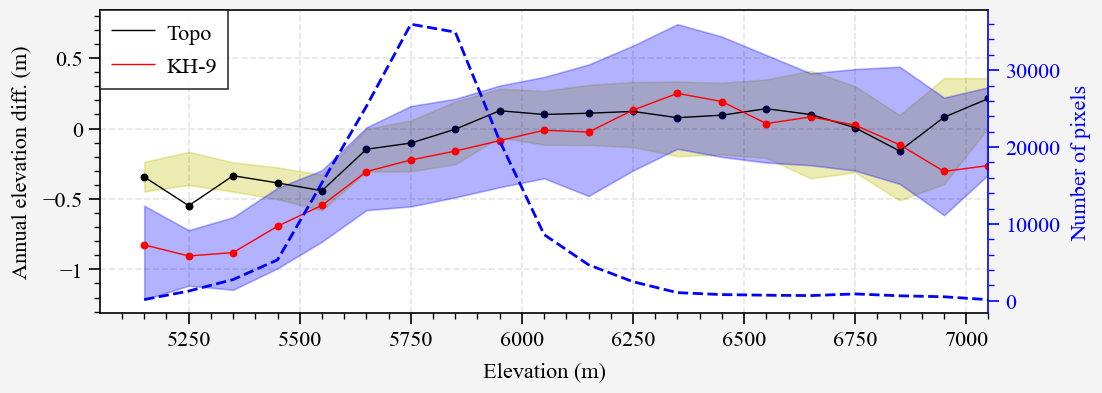

In [199]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")#中文支持，很重要
font1 = FontProperties(family='times new roman',style='normal',weight='normal') #设置新罗马

plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
arr=[[1,]]
fig, axs = plot.subplots(arr, figsize=('14cm','5cm'),
                         sharex=0,sharey=0,hspace=0.05,wspace=0.24)
################ topo
lg1=axs[0].fill_between(q25_wq.index,q25_wq['dh'].values/30, q75_wq['dh'].values/30,alpha=0.3,color='y')
#lg2=axs[0].fill_between(q05.index,q05['dh'].values, q95['dh'].values,alpha=0.3,color='gray')
lg2=axs[0].scatter(mea_wq.index,mea_wq['dh'].values/30,marker='.',s=20,color='k')
lg3=axs[0].plot(mea_wq.index,mea_wq['dh'].values/30,color='k',lw=0.5)

axt=axs[0].twinx()
axt.plot(cnt_wq.dem,ls='--',lw=1,c='b')
#######
################ topo
lg1=axs[0].fill_between(q25_wq.index,q25_wq['kh_dh'].values/32, q75_wq['kh_dh'].values/30,alpha=0.3,color='b')
#lg2=axs[0].fill_between(q05.index,q05['kh_dh'].values, q95['kh_dh'].values,alpha=0.3,color='b')
lg2=axs[0].scatter(mea_wq.index,mea_wq['kh_dh'].values/32,marker='.',s=20,color='r')
lg31=axs[0].plot(mea_wq.index,mea_wq['kh_dh'].values/32,color='r',lw=0.5)

axs[0].format(xlim=(5050,7050),ylabel='Annual elevation diff. (m)',xlabel='Elevation (m)')
axt.format(ylabel='Number of pixels',ycolor='b')
axs[0].legend([lg3,lg31],['Topo','KH-9'],loc=2,ncol=1,borderaxespad=0)
#plt.savefig('00fig_out/comparision_westnq.svg',dpi=300,bbox_inches = 'tight')

In [200]:
dxt_prj_wq1=dxt_prj_wq.sel(x=dxt_prj_wq.x.values[::2],y=dxt_prj_wq.y.values[::2])
dxt_prj_wq11=dxt_prj_wq1.where((dxt_prj_wq1<90)&(dxt_prj_wq1>-90))
kh_wq1=kh_wq.sel(x=kh_wq.x.values[::2],y=kh_wq.y.values[::2])

#### 绘图1

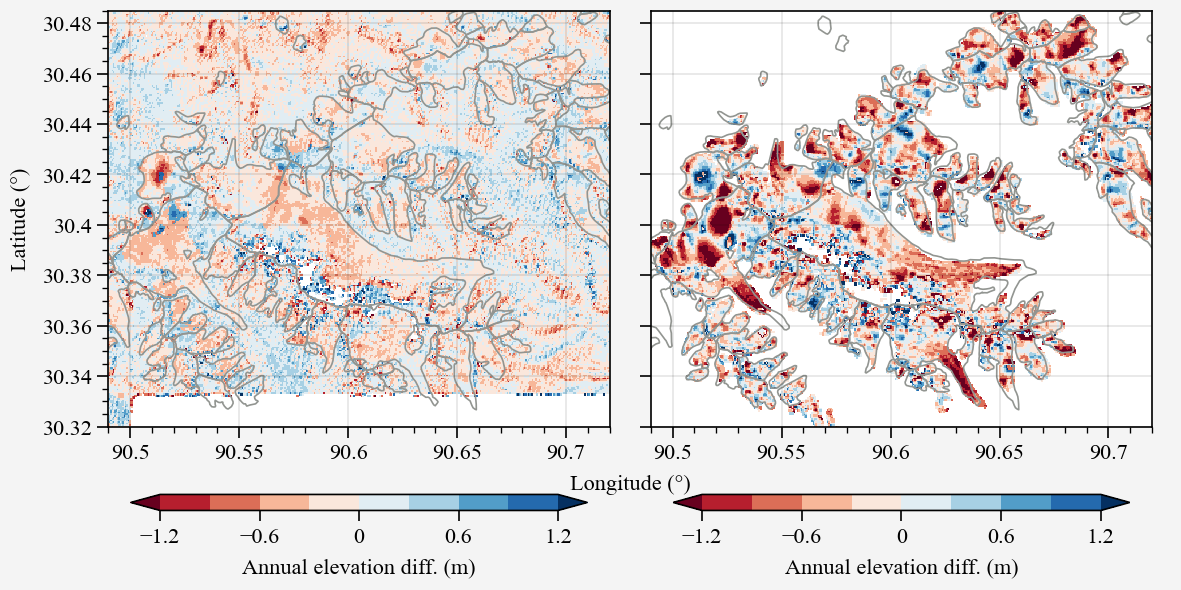

In [26]:
arr=[[1,2]]
fig, axs = plot.subplots(arr, figsize=('15cm','7.5cm'),
                         share=1,hspace=0.05,wspace=0.24)

#cs1=(dxt_prj1/30).plot(ax=axs[0],add_colorbar=False,vmax=1.5,vmin=-1.5,cmap='coolwarm')
cs1=axs[0].pcolormesh((dxt_prj_wq11/30)[0],colorbar=False,cmap='RdBu',vmax=1.5,vmin=-1.5,extend='both')
ds_gla_wq.plot(ax=axs[0],facecolor='none',edgecolor='gray')
axs[0].colorbar(cs1, loc='b',length=0.85,width=0.080,tickminor=False,pad=0,extend='both',
                label='Annual elevation diff. (m)')
#dem_prj.plot(ax=axs[0],add_colorbar=False)
##########3
#cs2=(kh_gurla1/32).plot(ax=axs[1],add_colorbar=False,vmax=1.5,vmin=-1.5,cmap='coolwarm')
cs2=axs[1].pcolormesh((kh_wq1/32)[0],colorbar=False,cmap='RdBu',vmax=1.5,vmin=-1.5,extend='both')
ds_gla_wq.plot(ax=axs[1],facecolor='none',edgecolor='gray')
axs[1].colorbar(cs2, loc='b',length=0.85,width=0.080,tickminor=False,pad=0,extend='both',
               label='Annual elevation diff. (m)')
axs.format(ylim=(30.32,30.485),xlim=(90.49,90.72),title='',
           xlabel='Longitude (°)',ylabel='Latitude (°)',grid=True,)
#axs.format(ylim=(30.32,30.485),xlim=(90.5,90.72),title='',xlabel='',ylabel='')
axs[1].format(yticklabels=[])

#plt.savefig('00fig_out/comparision_wstnq_img1-large.tif',dpi=600,bbox_inches = 'tight')

#### 绘制所有的大图

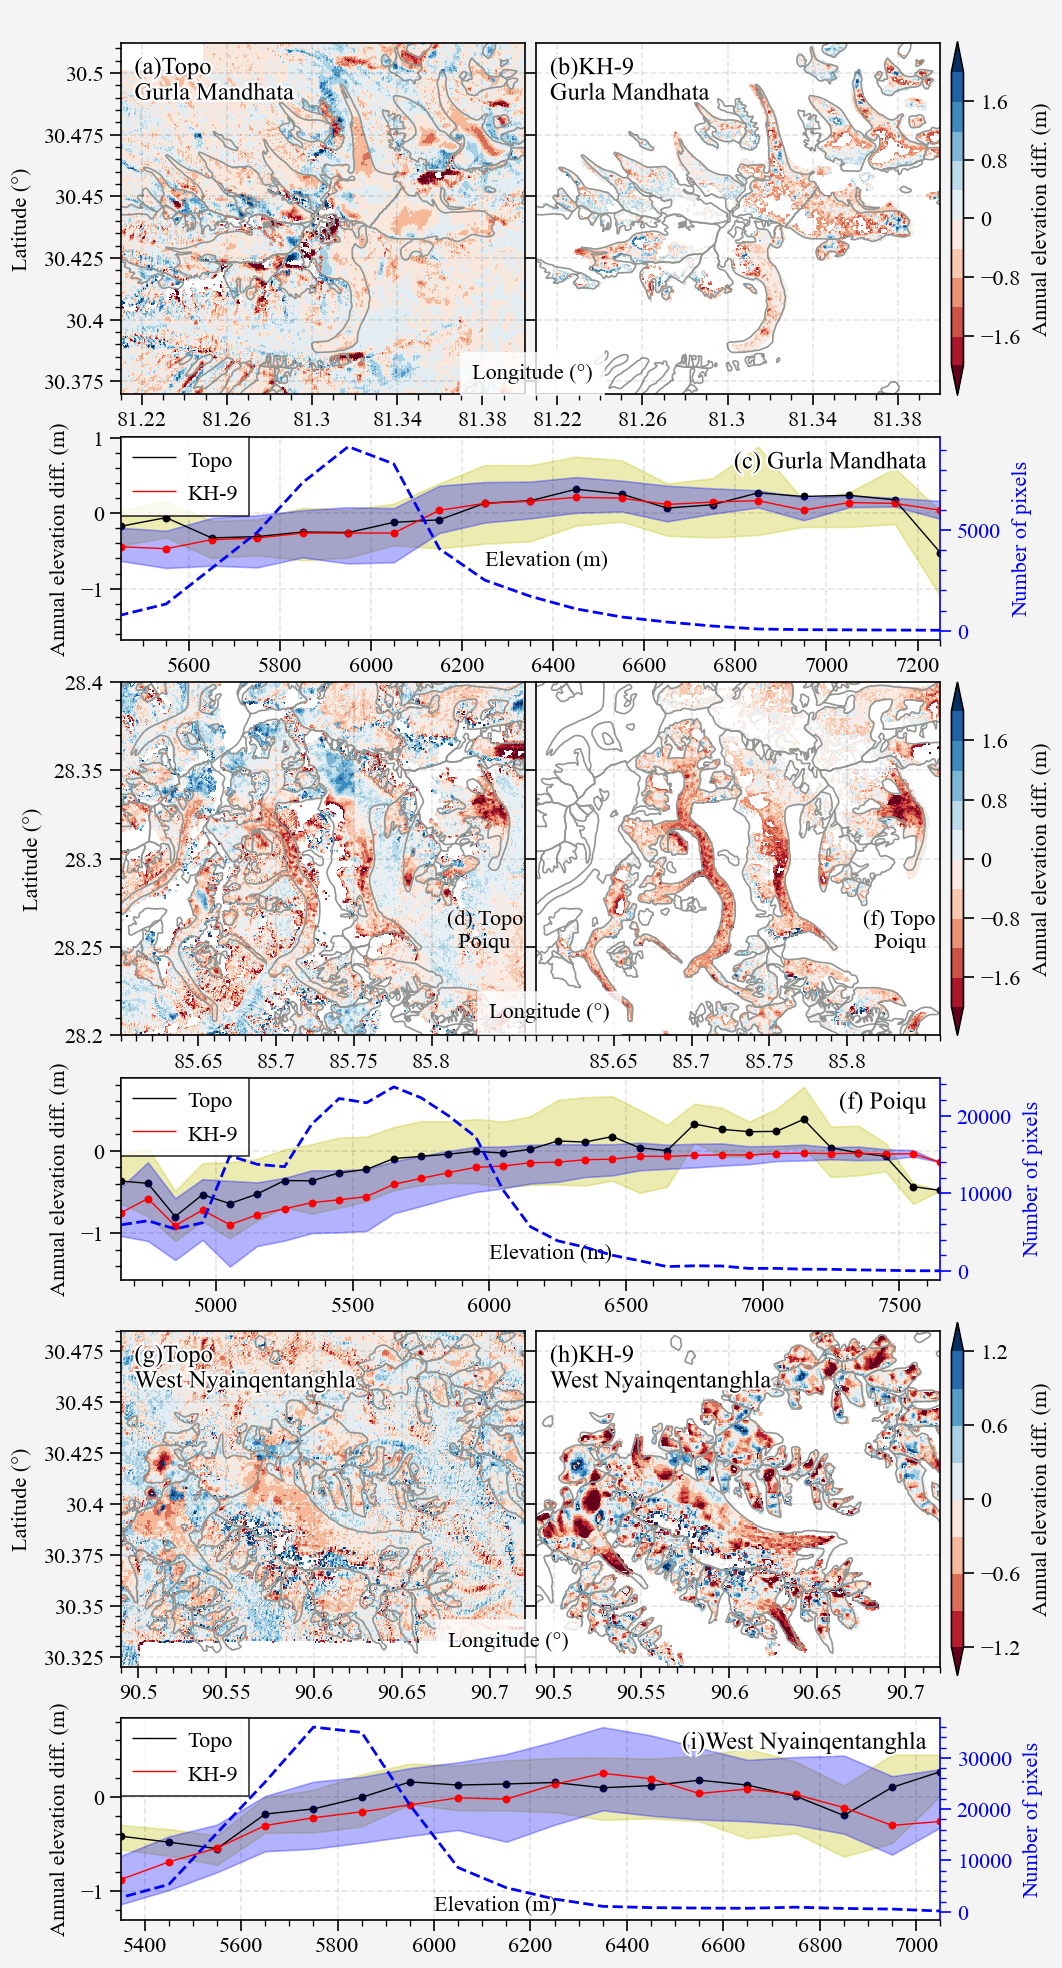

In [203]:
plt.rcParams['font.sans-serif']=['times new roman']
plt.rcParams['font.size']=8
plt.rcParams['grid.linestyle']='--'
arr=[[1,2],
     [1,2],
     [3,3],
     [4,5],
     [4,5],
     [6,6],
     [7,8],
     [7,8],
     [9,9]]
fig, axs = plot.subplots(arr, figsize=('13.5cm','25cm'),tight=True,
                         share=0,hspace=0.5,wspace=0.5)
#################################################
cs1=axs[0].pcolormesh((dxt_prj/26)[0],colorbar=False,cmap='RdBu',vmax=3,vmin=-3,extend='both')
cs2=axs[1].pcolormesh((kh_gurla/34)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
axs[1].colorbar(cs2, loc='r',length=0.85,width=0.060,tickminor=False,pad=0.5,extend='both',
               label='Annual elevation diff. (m)')
ds_gla.plot(ax=axs[0],facecolor='none',edgecolor='gray')
ds_gla.plot(ax=axs[1],facecolor='none',edgecolor='gray')

axs[0].format(ylim=(30.37,30.512),xlim=(81.21,81.4),title='',
              grid=True,ylabel='Latitude (°)',xlabel='',
              xticks=[81.22,81.26,81.3,81.34,81.38],ultitle='(a)Topo\nGurla Mandhata')
axs[1].format(ylim=(30.37,30.512),xlim=(81.21,81.4),yticklabels=[],xlabel='',ylabel='',
              xticks=[81.22,81.26,81.3,81.34,81.38],title='',
              grid=True,ultitle='(b)KH-9\nGurla Mandhata')

#########
lg1=axs[2].fill_between(q25.index,q25['dh'].values/26, q75['dh'].values/26,alpha=0.3,color='y')
lg3=axs[2].scatter(mea.index,mea['dh'].values/26,marker='.',s=20,color='k')
lg3=axs[2].plot(mea.index,mea['dh'].values/26,color='k',lw=0.5)

axt2=axs[2].twinx()
axt2.plot(cnt.dem,ls='--',lw=1,c='b')

lg1=axs[2].fill_between(q25.index,q25['kh_dh'].values/34, q75['kh_dh'].values/34,alpha=0.3,color='b')
lg2=axs[2].scatter(mea.index,mea['kh_dh'].values/34,marker='.',s=20,color='r')
lg31=axs[2].plot(mea.index,mea['kh_dh'].values/34,color='r',lw=0.5)
axs[2].format(xlim=(5450,7250),ylabel='Annual elevation diff. (m)',xlabel='',urtitle='(c) Gurla Mandhata')
axt2.format(ylabel='Number of pixels',ycolor='b')
axs[2].legend([lg3,lg31],['Topo','KH-9'],loc=2,ncol=1,borderaxespad=0)
################################################################poiqu
cs3=axs[3].pcolormesh((dxt_prj_pq11/26)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
cs4=axs[4].pcolormesh((kh_pq1/30)[0],colorbar=False,cmap='RdBu',vmax=2,vmin=-2,extend='both')
axs[4].colorbar(cs4, loc='r',length=0.85,width=0.060,tickminor=False,pad=0.5,extend='both',
               label='Annual elevation diff. (m)')
ds_gla_pq.plot(ax=axs[3],facecolor='none',edgecolor='gray')
ds_gla_pq.plot(ax=axs[4],facecolor='none',edgecolor='gray')


axs[3].format(ylim=(28.2,28.4),xlim=(85.60,85.86),title='',
           grid=True,ylabel='Latitude (°)',xlabel='',
           yticks=[28.2,28.25,28.3,28.35,28.4],xticks=[85.65,85.7,85.75,85.8])
axs[4].format(ylim=(28.2,28.4),xlim=(85.60,85.86),yticklabels=[],xlabel='',ylabel='',
              yticks=[28.2,28.25,28.3,28.35,28.4],title='',xticks=[85.65,85.7,85.75,85.8],
              grid=True)
########
lg1=axs[5].fill_between(q25_pq.index,q25_pq['dh'].values/26, q75_pq['dh'].values/26,alpha=0.3,color='y')
lg2=axs[5].scatter(mea_pq.index,mea_pq['dh'].values/26,marker='.',s=20,color='k')
lg3=axs[5].plot(mea_pq.index,mea_pq['dh'].values/26,color='k',lw=0.5)

axt5=axs[5].twinx()
axt5.plot(cnt_pq.dem,ls='--',lw=1,c='b')

lg1=axs[5].fill_between(q25_pq.index,q25_pq['kh_dh'].values/30, q75_pq['kh_dh'].values/30,alpha=0.3,color='b')
lg2=axs[5].scatter(mea_pq.index,mea_pq['kh_dh'].values/30,marker='.',s=20,color='r')
lg31=axs[5].plot(mea_pq.index,mea_pq['kh_dh'].values/30,color='r',lw=0.5)

axs[5].format(xlim=(4650,7650),ylabel='Annual elevation diff. (m)',xlabel='',urtitle='(f) Poiqu')
axt5.format(ylabel='Number of pixels',ycolor='b')
axs[5].legend([lg3,lg31],['Topo','KH-9'],loc=2,ncol=1,borderaxespad=0)

######################################################################wq
cs6=axs[6].pcolormesh((dxt_prj_wq11/24)[0],colorbar=False,cmap='RdBu',vmax=1.5,vmin=-1.5,extend='both')
cs7=axs[7].pcolormesh((kh_wq1/32)[0],colorbar=False,cmap='RdBu',vmax=1.5,vmin=-1.5,extend='both')
axs[7].colorbar(cs7, loc='r',length=0.85,width=0.060,tickminor=False,pad=0.5,extend='both',
                label='Annual elevation diff. (m)')

ds_gla_wq.plot(ax=axs[6],facecolor='none',edgecolor='gray')
ds_gla_wq.plot(ax=axs[7],facecolor='none',edgecolor='gray')

axs[6].format(ylim=(30.32,30.485),xlim=(90.49,90.72),title='',
           grid=True,ylabel='Latitude (°)',xlabel='',ultitle='(g)Topo\nWest Nyainqentanghla')
axs[7].format(ylim=(30.32,30.485),xlim=(90.49,90.72),yticklabels=[],
              title='',xlabel='',ylabel='',grid=True,ultitle='(h)KH-9\nWest Nyainqentanghla')

##########
lg1=axs[8].fill_between(q25_wq.index,q25_wq['dh'].values/24, q75_wq['dh'].values/24,alpha=0.3,color='y')
lg2=axs[8].scatter(mea_wq.index,mea_wq['dh'].values/24,marker='.',s=20,color='k')
lg3=axs[8].plot(mea_wq.index,mea_wq['dh'].values/24,color='k',lw=0.5)

axt8=axs[8].twinx()
axt8.plot(cnt_wq.dem,ls='--',lw=1,c='b')

lg1=axs[8].fill_between(q25_wq.index,q25_wq['kh_dh'].values/32, q75_wq['kh_dh'].values/30,alpha=0.3,color='b')
lg2=axs[8].scatter(mea_wq.index,mea_wq['kh_dh'].values/32,marker='.',s=20,color='r')
lg31=axs[8].plot(mea_wq.index,mea_wq['kh_dh'].values/32,color='r',lw=0.5)

axs[8].format(xlim=(5350,7050),ylabel='Annual elevation diff. (m)',xlabel='',urtitle='(i)West Nyainqentanghla')
axt8.format(ylabel='Number of pixels',ycolor='b')
axs[8].legend([lg3,lg31],['Topo','KH-9'],loc=2,ncol=1,borderaxespad=0)
#############################################################3
axs[1].text(81.18,30.376,'Longitude (°)',bbox={'facecolor': 'w', 'alpha': 0.8,'edgecolor':'w'})
axs[2].text(6250,-0.69,'Elevation (m)')
axs[4].text(85.57,28.21,'Longitude (°)',bbox={'facecolor': 'w', 'alpha': 0.8,'edgecolor':'w'})
axs[5].text(6000,-1.3,'Elevation (m)')
axs[3].text(85.81,28.25,'(d) Topo\n  Poiqu')
axs[4].text(85.81,28.25,'(f) Topo\n  Poiqu')

axs[7].text(90.44,30.33,'Longitude (°)',bbox={'facecolor': 'w', 'alpha': 0.8,'edgecolor':'w'})
axs[8].text(6000,-1.2,'Elevation (m)')

plt.savefig('TOPO_KH9_RES/comparision_all-large.tif',dpi=600,bbox_inches = 'tight')